In [ ]:
path = f'drive/MyDrive/moroccan-darija-trigger-word-classification-ed-2/'

import librosa
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import pandas as pd
import numpy as np
import os
from PIL import Image
import pathlib
import csv


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, 
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')


1. Loading an audio file

This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono

In [ ]:
audio_data = path + 'music1.wav'
x , sr = librosa.load(audio_data )
print(type(x), type(sr))
print(x.shape, sr)
len(x)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


661794

2. Playing Audio:

In [ ]:
ipd.Audio(audio_data)

3. Visualizing Audio:

We can plot the audio array using librosa.display.waveplot:

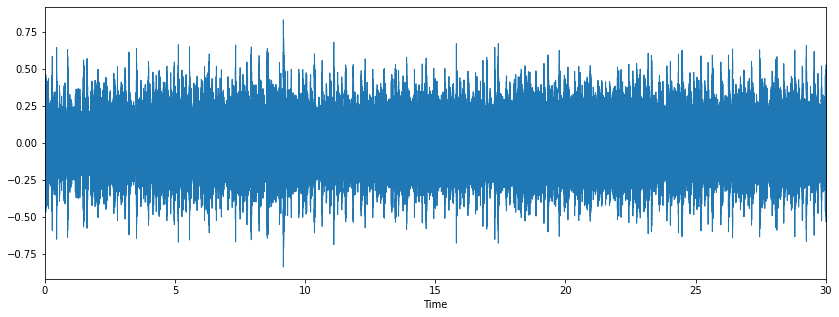

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

We can display a spectrogram using. librosa.display.specshow.

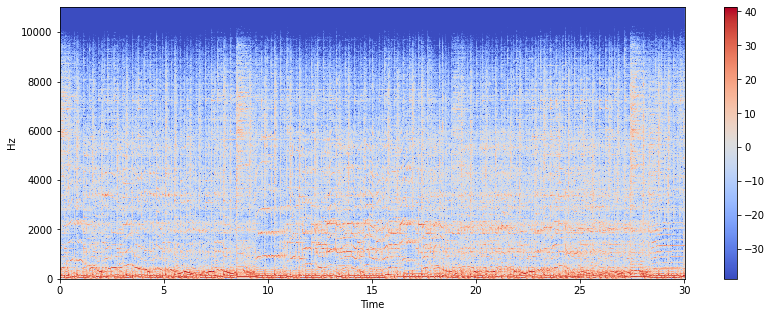

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

# Feature extraction from Audio signal

1. Spectral Centroid

The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. 

librosa.feature.spectral_centroid computes the spectral centroid for each frame in a signal and will return an array with columns equal to a number of frames present in your sample.

In [ ]:
librosa.feature.spectral_centroid(x, sr=sr)

array([[2314.0070493 , 2661.65184298, 3162.69526471, ..., 2751.94826706,
        2530.3172848 , 1920.93833352]])

(1293,)


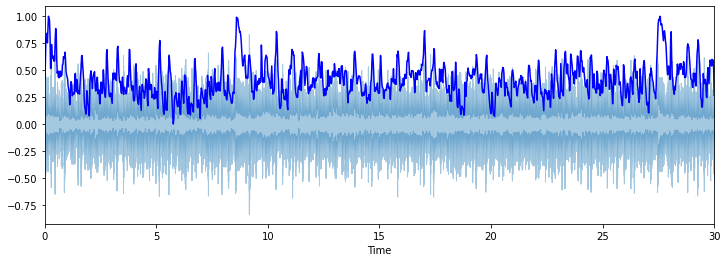

In [ ]:

spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(spectral_centroids.shape)

# Computing the time variable for visualization
plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

2. Spectral Rolloff

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

librosa.feature.spectral_rolloff computes the rolloff frequency for each frame in a signal:

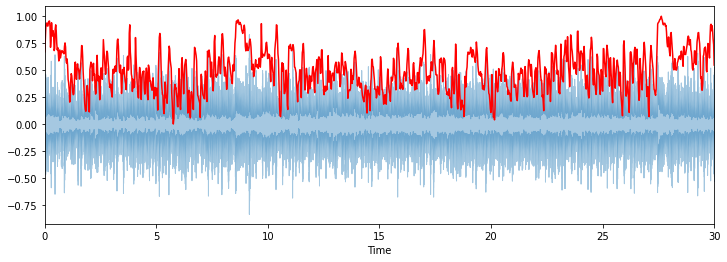

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr , )[0]
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')


3. Spectral Bandwidth

The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

librosa.feature.spectral_bandwidth computes the order-p spectral bandwidth:

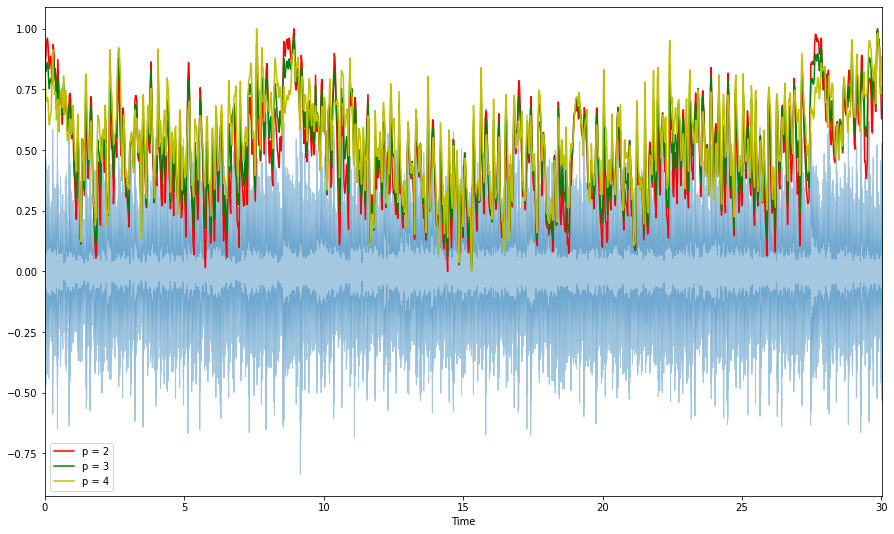

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
plt.figure(figsize=(15, 9))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

4. Zero-Crossing Rate

A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

It usually has higher values for highly percussive sounds like those in metal and rock.

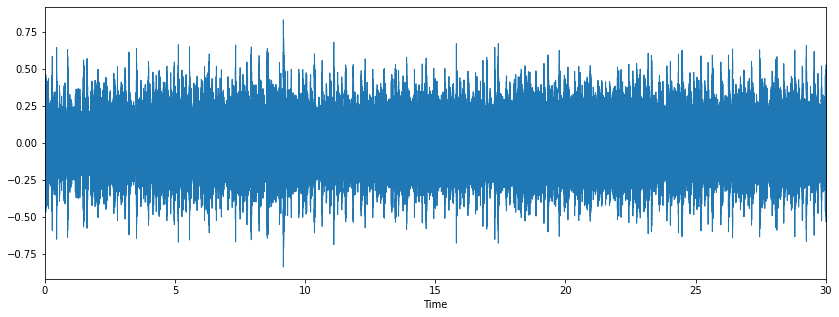

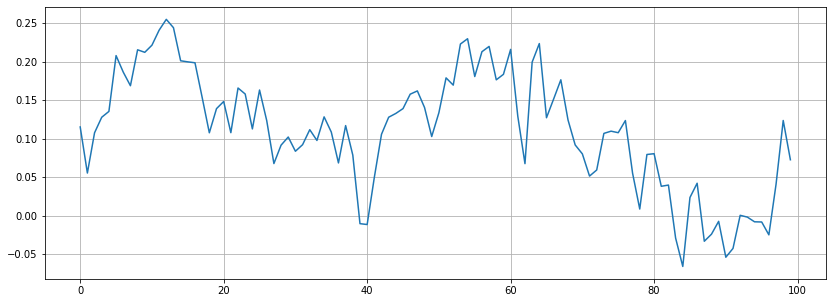

In [ ]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

8


5. Mel-Frequency Cepstral Coefficients(MFCCs)

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

(20, 1293)


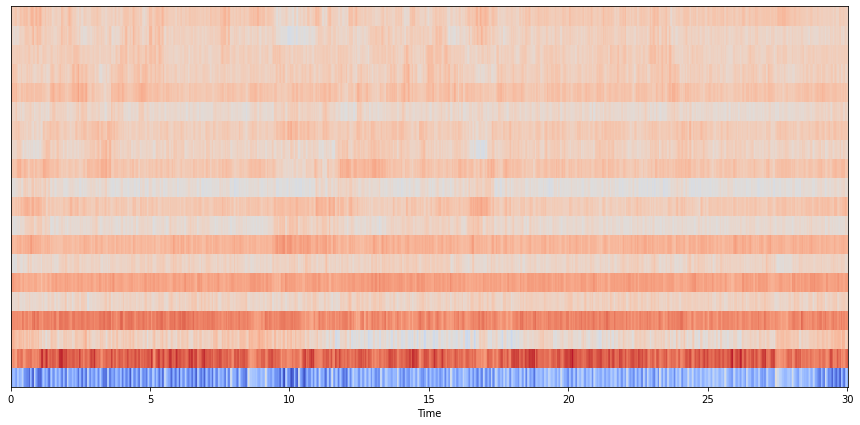

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr ,)
print(mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

6. Chroma feature

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. In short, It provides a robust way to describe a similarity measure between music pieces.

librosa.feature.chroma_stft is used for the computation of Chroma features.

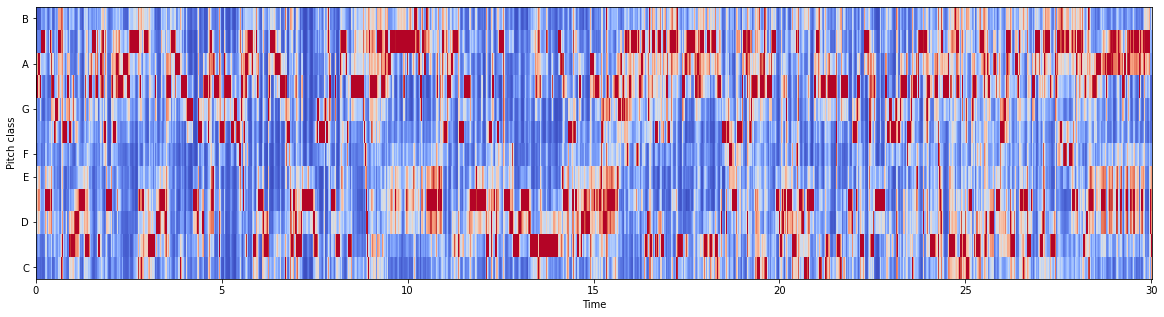

In [ ]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length )
plt.figure(figsize=(20, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

- Creating a header for our CSV file.

In [ ]:
header = 'length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var '
header += 'rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var tempo'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'
header += ' label'
header = header.split()

Extracting features from Spectrogram: We will extract Mel-frequency cepstral coefficients (MFCC), Spectral Centroid, Zero Crossing Rate, Chroma Frequencies, and Spectral Roll-off

In [ ]:
train = pd.read_csv(path+'train.csv')
train.head()

,id,label
0,gudj6np7lx4ov5a9y3wq,1
1,mi2z51y4jb7thxuf8ldr,1
2,ziuab84tvf07snxjhyodp,0
3,ulcdyxnbz6jqh9wmk4pa,1
4,gj8rfxzae4vibtohk62n1,0


In [ ]:
train.loc[0,'id']

'gudj6np7lx4ov5a9y3wq'

In [ ]:
hop_length = 512
file = open('traindata.csv', 'w', newline='')
train = pd.read_csv(path+'train.csv')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for i in range(train.shape[0]):
    #print(filename)
    songname = path +'data/train/'+ train.loc[i,'id'] + '.wav'
    y, sr = librosa.load(songname, mono=True, duration=30)
    lenght = len(y)
    rms = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    ###---------- to comment previous 
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    # Estimate the global tempo for display purposes
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    label = train.loc[i,'label']
    to_append = f'{lenght} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)}'
    to_append += f' {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {tempo}'    
    for e in mfcc:
      to_append += f' {np.mean(e)} {np.var(e)}'
    to_append += f' {label}'
    file = open('traindata.csv', 'a', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

### TASK 3

In [ ]:
df = pd.read_csv('traindata.csv')
print(df.shape)
df.head()


(144, 55)


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,63975,0.342925,0.095621,0.013850,0.000460,2050.808360,1.039156e+06,1878.012635,359133.791270,4155.822070,2.764510e+06,0.122445,0.007441,89.102909,-502.859070,17440.017578,93.467918,3372.671631,15.825174,1407.023804,40.827469,372.961609,-5.906100,453.751770,-1.794939,723.689514,-14.319454,658.020325,4.393899,146.840103,0.970841,40.671688,-11.095880,136.275681,-1.891995,43.315243,-5.200778,39.903908,-4.753117,70.095100,1.176110,29.773243,-0.593133,26.588615,-10.355734,118.815926,2.252659,76.583275,0.816094,37.396591,-5.553577,33.983799,-0.021178,33.277966,1
1,62093,0.426808,0.095766,0.019093,0.000786,2350.131459,1.083316e+06,1994.884825,242470.858436,4885.036581,1.850780e+06,0.166780,0.012243,143.554688,-421.461426,18919.697266,98.707733,1835.324951,-6.108032,166.598038,35.029503,401.266083,-43.955406,672.213379,23.039188,705.254333,-25.414425,478.410187,-0.510366,82.015350,-0.311831,46.799057,-10.694397,50.056026,2.379699,26.593269,-6.822119,42.484230,8.700195,42.483482,-7.198664,72.579483,5.933751,67.477463,1.460976,22.679417,-3.793310,35.040031,-1.520844,50.302235,-8.776588,56.228016,-4.931154,28.000128,1
2,47040,0.149157,0.068027,0.020368,0.001107,741.383026,1.686298e+06,773.501969,857236.909436,1482.982337,4.597126e+06,0.047576,0.004426,112.347147,-524.353333,31301.283203,58.893566,6122.330078,1.042949,177.001434,7.293238,146.983521,-14.680787,657.067871,17.796522,673.279785,-6.784839,154.025055,-3.252528,127.695900,-2.469809,41.019703,-8.433767,187.802750,2.156028,48.942162,-3.816120,36.861305,0.820075,24.087896,-2.693388,30.488819,-2.406468,34.226383,-2.518225,26.021845,-0.886567,17.495991,-2.099443,24.577917,-2.153026,20.077808,-1.494852,11.603216,0
3,60212,0.240998,0.096759,0.166317,0.008053,1904.059030,1.018420e+05,1400.396778,37150.319730,3526.518224,7.587134e+05,0.123341,0.000868,135.999178,-198.110474,6116.698730,96.035568,1259.522949,-105.603966,299.375916,-2.196633,1050.837402,-58.829826,354.095032,10.316247,461.524445,-9.367246,748.107239,-17.461594,421.357147,2.877186,155.811523,-12.702159,218.796219,-1.516269,161.916275,-14.595810,173.183350,-8.023369,199.082565,-12.936736,125.101746,-3.157641,147.249054,-15.155652,127.886978,-14.070888,113.742523,-1.204119,177.030533,-14.867137,447.704071,9.038553,135.653198,1
4,60212,0.107204,0.063533,0.004749,0.000085,617.214847,1.161545e+06,569.910757,713869.872568,1095.273603,3.566297e+06,0.030973,0.003189,161.499023,-701.895813,19396.783203,35.877903,3726.504883,-3.346734,607.479858,11.753732,681.643799,-12.008053,531.063232,-1.926270,132.801697,-8.108229,234.466278,-10.126281,276.210541,-1.519503,109.811806,-3.617314,76.499420,-0.282734,33.271004,-4.918725,110.428383,-3.973879,54.881058,-0.749546,22.474209,-3.995527,76.420601,-4.106721,67.638046,0.226041,32.334293,-1.167242,29.339811,-2.613620,32.658470,-1.406990,28.801468,0


In [ ]:
df.shape

(144, 55)

In [ ]:
y = df['label'].values
y

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
y = df['label'].values

#encoder = LabelEncoder()

#y = encoder.fit_transform(y) 

#Scaling the Feature columns
scaler = StandardScaler()
X = np.array(df.iloc[:, 14:54],dtype = float)

#Dividing data into training and Testing set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
#X = scaler.fit_transform(X)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
y

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [ ]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'], )

In [ ]:
classifier = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10, batch_size=16  )

Epoch 1/10
9/9 [==============================] - 0s 13ms/step - loss: 0.2160 - accuracy: 0.8992 - val_loss: 0.5244 - val_accuracy: 0.8000
Epoch 2/10
9/9 [==============================] - 0s 9ms/step - loss: 0.1470 - accuracy: 0.9535 - val_loss: 0.6655 - val_accuracy: 0.8000
Epoch 3/10
9/9 [==============================] - 0s 9ms/step - loss: 0.1207 - accuracy: 0.9457 - val_loss: 0.7720 - val_accuracy: 0.8000
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 0.1050 - accuracy: 0.9612 - val_loss: 0.7718 - val_accuracy: 0.8000
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 0.0926 - accuracy: 0.9612 - val_loss: 0.8083 - val_accuracy: 0.8000
Epoch 6/10
9/9 [==============================] - 0s 9ms/step - loss: 0.1311 - accuracy: 0.9457 - val_loss: 0.8199 - val_accuracy: 0.8000
Epoch 7/10
9/9 [==============================] - 0s 10ms/step - loss: 0.1153 - accuracy: 0.9612 - val_loss: 0.8486 - val_accuracy: 0.8000
Epoch 8/10
9/9 [===============

In [ ]:
model.evaluate(X_val,y_val)

1/1 [==============================] - 0s 22ms/step - loss: 0.4803 - accuracy: 0.8000


[0.4802888035774231, 0.800000011920929]

In [ ]:
header = 'length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var '
header += 'rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var tempo'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'

header = header.split()

In [ ]:
hop_length = 512
file = open('testdata.csv', 'w', newline='')
test = pd.read_csv(path+'test.csv')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for i in range(test.shape[0]):
    #print(filename)
    songname = path +'data/test/'+ test.loc[i,'id'] + '.wav'
    y, sr = librosa.load(songname, mono=True, duration=30)
    lenght = len(y)
    rms = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    ###---------- to comment previous 
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    # Estimate the global tempo for display purposes
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    
    to_append = f'{lenght} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rms)} {np.var(rms)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)}'
    to_append += f' {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {tempo}'    
    for e in mfcc:
      to_append += f' {np.mean(e)} {np.var(e)}'
    #to_append += f' {label}'
    file = open('testdata.csv', 'a', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

In [ ]:
testdata = pd.read_csv('testdata.csv')
testdata.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,45159,0.441354,0.087792,0.004735,0.000102,2437.810262,9.394861e+05,2335.059758,233816.161620,4958.080506,3.643583e+06,0.165423,0.007216,151.999081,-550.699707,9375.085938,82.001534,1375.247070,-0.165784,781.872620,-3.039189,396.779663,0.020185,428.089935,-8.484112,170.114609,-12.233017,277.238770,0.980879,174.445221,-17.612967,295.341827,-6.485292,99.645828,-7.545806,123.544617,-4.579393,81.143898,-0.447433,51.847923,1.792256,46.501099,-4.453272,53.184204,-2.817069,133.900391,-4.703905,51.283695,-3.062992,112.540169,-4.184604,66.883057,-2.134758,65.781403
1,45159,0.494598,0.088401,0.033311,0.003078,2652.115601,1.385079e+06,1884.763497,442759.591570,4692.181739,3.305446e+06,0.296436,0.026889,117.453835,-463.530457,34332.886719,58.246586,7851.924805,-20.066782,1439.022339,23.965975,905.070862,-17.716976,640.429993,-2.613579,224.402649,-3.434292,85.667603,-5.524589,79.369385,-8.030900,231.644485,-8.716646,112.360519,5.188810,177.918381,-6.384327,95.431786,-1.658048,27.307123,-4.538339,67.324348,-4.748723,65.667625,2.017478,54.115784,-4.541757,70.493721,-2.947192,37.724918,-0.105787,27.504662,-3.906042,60.609150
2,63975,0.310644,0.103272,0.044679,0.005437,1473.819835,3.420718e+05,1542.845446,193826.567737,2890.875586,2.181133e+06,0.094047,0.003763,103.359375,-426.419312,27982.857422,85.487579,3687.760742,-15.445258,2228.456055,17.008890,497.503326,-12.384083,1130.560425,-6.191247,319.930420,-4.464761,335.614227,-15.838090,284.486023,-19.957785,236.602692,-8.690031,154.603592,-3.981840,142.657852,-8.408197,216.203995,-5.840009,178.490891,-8.817952,247.553635,-0.188890,184.538895,-4.276045,140.402283,-5.945516,124.420418,-6.006531,71.377625,-9.684734,109.212944,-4.825141,73.321350
3,56448,0.443941,0.113698,0.058724,0.008351,2801.819307,2.283896e+06,1954.753173,726467.934151,4868.443834,5.468850e+06,0.251658,0.028319,99.384014,-389.339081,27387.324219,43.019524,3673.111572,-15.780594,1233.123169,17.706635,929.112244,-18.089523,579.922241,-1.161802,470.715057,-18.989479,819.767029,-2.857850,208.369019,-7.604163,114.296425,-8.709813,120.204865,-3.582218,63.400517,-5.738280,73.867661,-1.573666,81.227936,-4.996249,83.367226,-1.243457,54.474430,-6.458755,86.483063,-1.599898,45.035442,-6.704511,66.880112,-3.173671,35.348663,-1.189107,34.832546
4,63975,0.336799,0.103364,0.028086,0.003269,1790.110927,1.309967e+06,1752.021411,433564.831022,3424.382227,4.698011e+06,0.136195,0.010186,151.999081,-432.207397,15994.875000,54.857368,2420.193115,10.856141,1046.676270,24.556007,1028.885254,-7.297643,400.489746,6.071050,436.180115,-12.906828,439.264587,-6.245788,226.549866,-1.330056,87.383926,-4.260362,86.485298,-7.865536,112.943840,-8.686956,105.725517,-4.538481,74.542236,-9.278646,118.948967,-2.647108,58.705822,-5.976314,70.883865,-0.758871,48.051449,-4.576164,53.726345,-3.677701,54.921131,-1.978459,72.270500


In [ ]:
X_test =  scaler.transform(np.array(testdata.iloc[:, 14:],dtype = float))
pred_labels = model.predict(X_test)
pred_labels

In [ ]:
print(X_train.shape , X_test.shape)

(129, 54) (82, 54)


In [ ]:
for i in range(len(pred_labels)):
  if pred_labels[i]>0.5 :
    pred_labels[i] = 1
  else : 
    pred_labels[i] = 0

In [ ]:
pred_labels = pred_labels.astype(int)

In [ ]:
ss = pd.read_csv(path+'sample_submission.csv')
ss['label'] = pred_labels
ss.head()

,id,label
0,4s8mxnikbt0f61qu2ea5,1
1,wcr5syvak4mq0tozn6i3d,1
2,qt6vl4jushkf7g5webcym,1
3,i84wvt3sa7golhud9x1f,1
4,o6013rbhaz94tlqmg8nc,1


In [ ]:
ss.to_csv('Sub8.csv', index=False)